[代码](https://www.heywhale.com/mw/project/5eafebf1366f4d002d75125c) 
[文档](https://hmmlearn.readthedocs.io/en/latest/)

## 连续型高斯分布

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator
from hmmlearn.hmm import GaussianHMM

code_val = "sz.000725"
data = pd.read_excel("E:\\All Files\\stock\\"+code_val+".xls","Sheet1")

In [3]:
# 日期格式转换
data['Date'] = pd.to_datetime(data['Date'], format = "%d/%m/%Y", errors = 'coerce')
data.head()

,Date,High,Low,Open,Close,Volume
0,2011-01-04,3.20,3.12,3.16,3.19,823311.00
1,2011-01-05,3.17,3.14,3.17,3.15,613076.68
2,2011-01-06,3.26,3.13,3.15,3.19,1033121.80
3,2011-01-07,3.21,3.15,3.17,3.17,764602.07
4,2011-01-10,3.17,3.10,3.17,3.11,574004.56


马尔可夫链从第二天开始训练，去除第一天的日期和交易量

In [4]:
dates = data['Date'].values[1:]
close_v = data['Close'].values
volume = data['Volume'].values[1:]

# 计算前后两天收盘价的差值
diff  = np.diff(close_v)
close_v = close_v[1:]

# 将数组按列合并
X = np.column_stack([diff,volume])
X.shape

(2431, 2)

建立模型
+ n_components 参数指定了使用3个隐藏层状态
+ covariance_type定义了协方差矩阵类型为对角线类型，即每个特征的高斯分布有自己的方差参数，相互之间没有影响
+ n_iter参数定义了Baum-Welch的最大迭代次数

In [5]:
model =  GaussianHMM(n_components=3, covariance_type="diag",n_iter=1000, algorithm='viterbi')
model.fit(X)

GaussianHMM(n_components=3, n_iter=1000)

每层的方差和平均值，X有两列（涨跌幅和成交量），因此每层都有涨跌幅均值和成交量均值

In [6]:
print("Means and vars of each hidden state")
means_ = []
vars_ = []
for i in range(model.n_components):
    means_.append(model.means_[i][0])
    vars_.append(np.diag(model.covars_[i])[0])
    print("第{0}号隐藏状态".format(i))
    print("mean = ", model.means_[i])
    print("var = ", np.diag(model.covars_[i]))

Means and vars of each hidden state
第0号隐藏状态
mean =  [-2.11290017e-03  8.57661345e+05]
var =  [1.09561944e-03 2.25957603e+11]
第1号隐藏状态
mean =  [-2.50047458e-03  3.66477834e+06]
var =  [3.48038413e-03 2.12623265e+12]
第2号隐藏状态
mean =  [1.15283100e-02 1.14864005e+07]
var =  [2.80731816e-02 3.62616807e+13]


特征数

In [7]:
model.n_features

2

状态数

In [8]:
model.n_components

3

观测集合

In [9]:
model.monitor_

ConvergenceMonitor(
    history=[-39423.21659390832, -36920.79847981348, -36149.78275849587, -35732.432148335036, -35507.56299402317, -35389.781765458065, -35320.22728402188, -35268.98420615596, -35220.482858756346, -35162.93737276044, -35118.803127121566, -35090.88727407402, -35074.00307686128, -35062.18543855802, -35054.88398906859, -35050.75398203086, -35048.267047937254, -35046.674818263746, -35045.6071069569, -35044.861343770935, -35044.3222505189, -35043.92224307741, -35043.62005746593, -35043.389228210435, -35043.2118748074, -35043.0753129577, -35042.97017576863, -35042.889346044925, -35042.827323244026, -35042.7798230285, -35042.74350332166, -35042.71576279891, -35042.69458492313, -35042.67841386127, -35042.66605483638, -35042.656594240565],
    iter=36,
    n_iter=1000,
    tol=0.01,
    verbose=False,
)

状态转移概率矩阵

In [10]:
print("Transition matrix")
print(model.transmat_)

Transition matrix
[[0.95937103 0.03781558 0.00281338]
 [0.03636129 0.90281956 0.06081914]
 [0.00293688 0.09216571 0.9048974 ]]


In [11]:
# 计算当前状态后一天的预测均值
predict_means = []
predict_vars = []

for idx, hid in enumerate(range(model.n_components)):   # 0 0 1 1 2 2
    comp = np.argmax(model.transmat_[idx]) # 最可能的第二天状态   # 返回一个numpy数组中最大值的索引值
    predict_means.append(means_[comp])
    predict_vars.append(vars_[comp])

print('predict_means',predict_means)
print('predict_vars',predict_vars)

predict_means [-0.002112900165966125, -0.00250047457664378, 0.011528309992299923]
predict_vars [0.0010956194431480677, 0.003480384125969792, 0.028073181624211685]


1. 计算出每一天状态
2. 通过概率转移矩阵得出之后一天概率最大的状态
3. 通过后一天的概率分布矩阵得出后一天的预测值

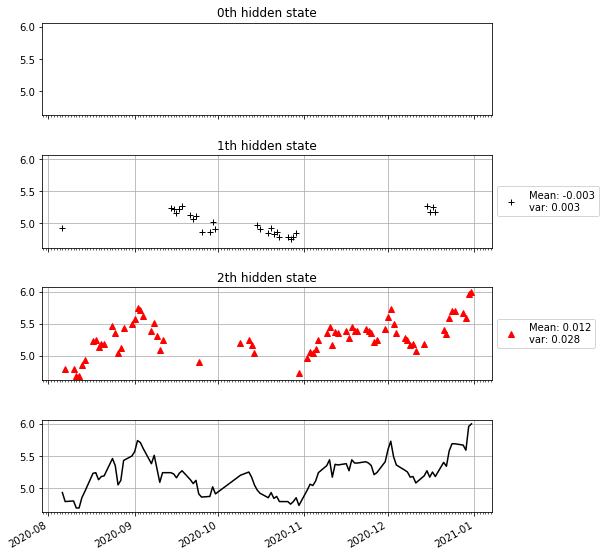

In [12]:
X = X[-100:]                      # 最后26天
dates = dates[-100:]
close_v = close_v[-100:]

hidden_states = model.predict(X)
hidden_states

# 画图
fig, axs = plt.subplots(model.n_components + 1, sharex=True, sharey=True,figsize=(10,10))

for i, ax in enumerate(axs[:-1]):
    ax.set_title("{0}th hidden state".format(i))

    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    yesterday_mask = np.concatenate(([False], mask[:-1]))
    if len(dates[mask]) <= 0:
        continue

    if predict_means[i] > 0.01:
        # 上涨预测
        ax.plot_date(dates[mask], close_v[mask], "^", c="#FF0000")
    elif predict_means[i] < -0.01:
        # 下跌预测
        ax.plot_date(dates[mask], close_v[mask], "v", c="#00FF00")
    else:
        # 平
        ax.plot_date(dates[mask], close_v[mask], "+", c="#000000")

    # locate specified days of the day
    ax.xaxis.set_minor_locator(DayLocator())

    ax.grid(True)
    ax.legend(["Mean: %0.3f\nvar: %0.3f" % (predict_means[i], predict_vars[i])],
        loc='center left',
        bbox_to_anchor=(1, 0.5))

# 打印真实走势,用作对比
axs[-1].plot_date(dates, close_v, "-", c='#000000')
axs[-1].grid(True)
box = axs[-1].get_position()
axs[-1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.xaxis.set_minor_locator(DayLocator())

# 调整格式
fig.autofmt_xdate()
plt.subplots_adjust(left=None, bottom=None, right=0.75, top=None, 
                    wspace=None, hspace=0.43)

plt.show()

## 2

In [13]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

PLOT_SHOW=True
PLOT_TYPE = False

NUM_TEST = 100
K = 50
NUM_ITERS=10000

STOCKS=['apple.csv','cmcst.csv','google.csv','qcom.csv']
#NUM_STATES=12
#FILE_NAME='HistoricalQuotes.csv'
#TRAIN_CHUNK_SIZE=100

#dirichlet_params = np.array([1., 20., 20., 20.])
#dirichlet_params = np.random.randint(1,50,NUM_STATES)
labels = ['Close','Open','High','Low']
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
bic_vect = np.empty([0,1])

# Possible number of states in Markov Model
STATE_SPACE = range(2,15)

# Calculating Mean Absolute Percentage Error of predictions
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])


for stock in STOCKS:
    dataset = np.genfromtxt(stock, delimiter=',')
    predicted_stock_data = np.empty([0,dataset.shape[1]])
    likelihood_vect = np.empty([0,1])
    aic_vect = np.empty([0,1])
    bic_vect = np.empty([0,1])
    for states in STATE_SPACE:
        num_params = states**2 + states
        dirichlet_params_states = np.random.randint(1,50,states)
        #model = hmm.GaussianHMM(n_components=states, covariance_type='full', startprob_prior=dirichlet_params_states, transmat_prior=dirichlet_params_states, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
        model.fit(dataset[NUM_TEST:,:])
        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
        aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
        bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))
    
    opt_states = np.argmin(bic_vect) + 2
    print('Optimum number of states are {}'.format(opt_states))

    for idx in reversed(range(NUM_TEST)):
        train_dataset = dataset[idx + 1:,:]
        test_data = dataset[idx,:]; 
        num_examples = train_dataset.shape[0]
        #model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', startprob_prior=dirichlet_params, transmat_prior=dirichlet_params, tol=0.0001, n_iter=NUM_ITERS, init_params='mc')
        if idx == NUM_TEST - 1:
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
        else:
            # Retune the model by using the HMM paramters from the previous iterations as the prior
            model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
            model.transmat_ = transmat_retune_prior 
            model.startprob_ = startprob_retune_prior
            model.means_ = means_retune_prior
            model.covars_ = covars_retune_prior

        model.fit(np.flipud(train_dataset))

        transmat_retune_prior = model.transmat_
        startprob_retune_prior = model.startprob_
        means_retune_prior = model.means_
        covars_retune_prior = model.covars_

        if model.monitor_.iter == NUM_ITERS:
            print('Increase number of iterations')
            sys.exit(1)
        #print('Model score : ', model.score(dataset))
        #print('Dirichlet parameters : ',dirichlet_params)

        iters = 1;
        past_likelihood = []
        curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
        while iters < num_examples / K - 1:
            past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
            iters = iters + 1
        likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
        predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
        predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))
    np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')

    mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
    print('MAPE for the stock {} is '.format(stock),mape)

    if PLOT_TYPE:
        hdl_p = plt.plot(range(100), predicted_stock_data);
        plt.title('Predicted stock prices')
        plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.figure()
        hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
        plt.title('Actual stock prices')
        plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
        plt.xlabel('Time steps')
        plt.ylabel('Price')
    else:
        for i in range(4):
            plt.figure()
            plt.plot(range(100), predicted_stock_data[:,i],'k-', label = 'Predicted '+labels[i]+' price');
            plt.plot(range(100),np.flipud(dataset[range(100),i]),'r--', label = 'Actual '+labels[i]+' price')
            plt.xlabel('Time steps')
            plt.ylabel('Price')
            plt.title(labels[i]+' price'+ ' for '+stock[:-4])
            plt.grid(True)
            plt.legend(loc = 'upper left')
        

    if PLOT_SHOW:
        plt.show(block=False)

OSError: apple.csv not found.